things to do tonite

rubik :

* bikin early stopper
* bikin pipeline input


# Perkenalan dan sumber masalah

source data : <https://data.mendeley.com/datasets/4drtyfjtfy/1?ref=hackernoon.com>

# Library

In [1]:
import pandas as pd
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Data Loading

In [2]:
train_folder=r'data/train'
val_folder=r'data/val'
test_folder=r'data/test'

In [3]:
import pathlib
data_dir = pathlib.Path(train_folder)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

787


In [4]:
IMG_WIDTH=317
IMG_HEIGHT=167
IMG_SIZE=(IMG_WIDTH,IMG_HEIGHT)
batch_size=4

In [5]:
train_dataset = image_dataset_from_directory(
    train_folder,
    shuffle=True,
    batch_size=batch_size,
    image_size=IMG_SIZE
    )

Found 787 files belonging to 4 classes.


In [6]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  val_folder,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 225 files belonging to 4 classes.


# Data Preprocessing

In [7]:
class_names = train_dataset.class_names
print(class_names)

['cloudy', 'rain', 'snine', 'sunrise']


In [8]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(4, 317, 167, 3)
(4,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(99).prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [11]:
normalized_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Model

## Base Model

Mantra Mantra

In [12]:
keras.backend.clear_session()

In [13]:
np.random.seed(69)
tf.random.set_seed(69)

### Data Augmentation layer

In [14]:
img_aug = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

> for simplicity, img_aug layer will be applied in every layer in every model

In [15]:
num_classes = 4

model = Sequential([
    img_aug,
    layers.InputLayer(input_shape=(IMG_WIDTH,IMG_HEIGHT, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 317, 167, 3)       0         
_________________________________________________________________
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              (None, 317, 167, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 158, 83, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 158, 83, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 79, 41, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 79, 41, 64)       

### Setup Early Stoping

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, baseline=0.75, restore_best_weights=True)


In [19]:
epochs=100

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[es],
)

Epoch 1/100
197/197 [==============================] - 7s 18ms/step - loss: 16.2913 - accuracy: 0.6239 - val_loss: 1.1094 - val_accuracy: 0.7378
Epoch 2/100
197/197 [==============================] - 3s 15ms/step - loss: 0.8500 - accuracy: 0.6518 - val_loss: 0.9022 - val_accuracy: 0.7289
Epoch 3/100
197/197 [==============================] - 3s 16ms/step - loss: 0.8614 - accuracy: 0.6798 - val_loss: 0.9140 - val_accuracy: 0.7244
Epoch 4/100
197/197 [==============================] - 3s 16ms/step - loss: 1.1076 - accuracy: 0.5934 - val_loss: 0.8446 - val_accuracy: 0.6667
Epoch 5/100
197/197 [==============================] - 3s 17ms/step - loss: 0.9895 - accuracy: 0.5527 - val_loss: 1.0263 - val_accuracy: 0.5422
Epoch 6/100
197/197 [==============================] - 4s 20ms/step - loss: 0.9302 - accuracy: 0.6061 - val_loss: 1.3479 - val_accuracy: 0.5778


## Base Model Evaluation

### Classification report Matrix

In [20]:
from sklearn.metrics import classification_report

In [21]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_folder, # Put your path here
     target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=4,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Found 113 images belonging to 4 classes.


In [22]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())   

In [23]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

      cloudy       0.54      0.90      0.68        30
        rain       1.00      0.09      0.17        22
       shine       0.88      0.60      0.71        25
     sunrise       0.82      1.00      0.90        36

    accuracy                           0.71       113
   macro avg       0.81      0.65      0.61       113
weighted avg       0.79      0.71      0.66       113



### Result Per Epoch

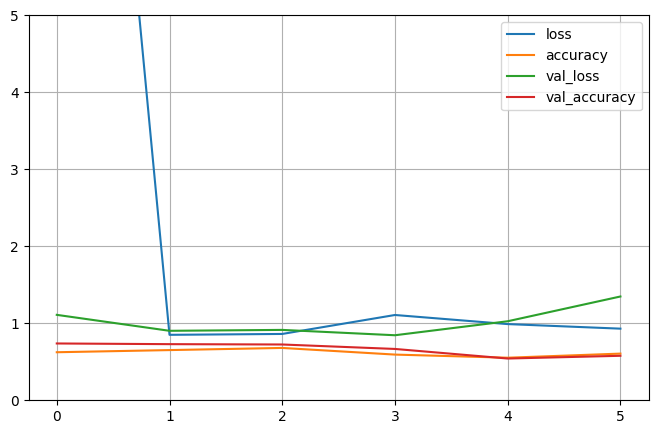

In [24]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca(),plt.ylim(0, 5)
plt.show()

## Transfer Learning with VGG16

In [198]:
keras.backend.clear_session()

In [199]:
np.random.seed(69)
tf.random.set_seed(69)

In [200]:
from keras.models import Sequential
from keras.layers import Dense
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

## Data Preprocessing

### resize the dataset to 224 X 224

In [201]:
IMG_SIZE = (224, 224)

In [202]:
train_dataset = image_dataset_from_directory(
    train_folder,
    shuffle=True,
    batch_size=batch_size,
    image_size=IMG_SIZE
    )

Found 787 files belonging to 4 classes.


In [203]:
train_dataset

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [204]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  val_folder,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 225 files belonging to 4 classes.


In [205]:
val_dataset

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [206]:
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 5)
val_dataset = val_dataset.skip(val_batches // 5)

In [207]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 46
Number of test batches: 11


In [209]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [226]:
train_dataset

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

### Image Augmentation

In [210]:
img_aug = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(224, 224, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [211]:
IMG_SHAPE = IMG_SIZE + (3,)

In [212]:
IMG_SHAPE

(224, 224, 3)

In [213]:
model_vgg16 = VGG16(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

In [214]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model_vgg16(image_batch)
print(feature_batch.shape)

(4, 7, 7, 512)


In [215]:
model_vgg16.trainable = False

In [216]:
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [217]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(4, 512)


In [218]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(4, 1)


In [242]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = img_aug(inputs)
x = model_vgg16(x, training=False)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(4)(x)
model = tf.keras.Model(inputs, outputs)

In [244]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [245]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 16)          73744     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 32)          4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 2, 2, 32)          0   

In [246]:
len(model.trainable_variables)

10

In [247]:
val_dataset

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [248]:
initial_epochs = 100

loss0, accuracy0 = model.evaluate(val_dataset)

46/46 [==============================] - 1s 19ms/step - loss: 5.5280 - accuracy: 0.1602


In [249]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 5.53
initial accuracy: 0.16


In [250]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)


In [251]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset,
                    callbacks=[es],)

Epoch 1/100
197/197 [==============================] - 7s 29ms/step - loss: 6.3174 - accuracy: 0.2922 - val_loss: 1.6578 - val_accuracy: 0.3315
Epoch 2/100
197/197 [==============================] - 6s 30ms/step - loss: 2.4653 - accuracy: 0.2745 - val_loss: 1.4793 - val_accuracy: 0.3425
Epoch 3/100
197/197 [==============================] - 6s 32ms/step - loss: 2.0523 - accuracy: 0.3126 - val_loss: 1.3804 - val_accuracy: 0.3204
Epoch 4/100
197/197 [==============================] - 6s 31ms/step - loss: 1.6731 - accuracy: 0.3240 - val_loss: 1.3843 - val_accuracy: 0.3481
Epoch 5/100
197/197 [==============================] - 6s 32ms/step - loss: 1.6966 - accuracy: 0.3316 - val_loss: 1.3863 - val_accuracy: 0.4696
Epoch 6/100
197/197 [==============================] - 6s 32ms/step - loss: 1.5662 - accuracy: 0.3151 - val_loss: 1.3863 - val_accuracy: 0.4696
Epoch 7/100
197/197 [==============================] - 6s 31ms/step - loss: 1.4976 - accuracy: 0.3367 - val_loss: 1.3863 - val_accuracy:

In [253]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_folder, # Put your path here
     target_size=(224, 224),
    batch_size=4,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Found 113 images belonging to 4 classes.


In [254]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())   

In [255]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

      cloudy       0.68      0.43      0.53        30
        rain       0.20      0.05      0.07        22
       shine       0.00      0.00      0.00        25
     sunrise       0.40      0.94      0.56        36

    accuracy                           0.42       113
   macro avg       0.32      0.36      0.29       113
weighted avg       0.35      0.42      0.33       113



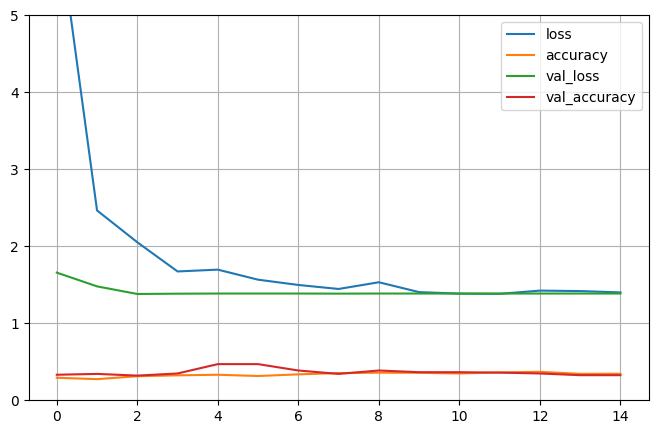

In [257]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca(),plt.ylim(0, 5)
plt.show()